In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch import autograd
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image

from datetime import datetime
from tqdm import tqdm
import os

EPOCH = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-1
# True表示需下载，False表示已下载
DOWNLOAD_MNIST = False

# 训练时才会标准化
im_tfs = tfs.Compose([
    # 先将输入归一化到(0,1)，再使用公式”(x-mean)/std”，将每个元素分布到(-1,1) 
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5])
])

train_set = MNIST('./mnist', transform=im_tfs, train=True, download=DOWNLOAD_MNIST)
train_data = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# 设置BATCH_SIZE = 128,则batch numbers = sum / 128 = 468,每次输入一个batch训练，迭代468次，为一轮
print(len(train_data))

valid_set = MNIST('./mnist', transform=im_tfs, train=False)
valid_data = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)


# test_set = MNIST('./mnist', train=False)

# print(train_set.data.size())
# print(train_set.data[0])
# print(train_set.targets.size())
# print(train_set.targets[0])

# for i, batch in enumerate(train_data):
#     print(i)
#     # batch[0]为数据,batch[1]为标签
#     print(batch[0], batch[1])

# plt.imshow(train_set.data[0].numpy(), cmap='gray')
# plt.title('%i' % train_set.targets[0])
# plt.show()

class VAE(nn.Module):
    def __init__(self, latent_num=2):
        super(VAE, self).__init__()
        
#         self.fc1 = nn.Linear(28*28, 400)
#         self.fc21 = nn.Linear(400, 20) # mean
#         self.fc22 = nn.Linear(400, 20) # var
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 28*28)
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.Linear(400,100),
            #nn.BatchNorm1d(100),
            #nn.ReLU(),
            #nn.Dropout(p=0.2),
        )
        
        self.fc1 = nn.Linear(400, 20)
        self.fc2 = nn.Linear(400, 20)
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.Linear(100,400),
            #nn.BatchNorm1d(400),
            #nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 28*28),
            nn.Tanh()
        )

    # q(z|x)
    def encode_q(self, x):
        h1 = self.encoder(x)
        return self.fc1(h1), self.fc2(h1)
    
    # 重参数化，使网络可以反向传播
    def reparametrize(self, mu, logvar):
        # mul逐乘
        # exp逐指数
        # exp_是exp的in-place形式
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = eps.cuda()
        # z = mu + sigma * eps
        return eps.mul(std).add_(mu)
    
    # p(x|z)
    def decoder_p(self, z):
        h2 = self.decoder(z)
        return h2

    def forward(self, x):
        mu, logvar = self.encode_q(x)
        z = self.reparametrize(mu, logvar)
        # 解码，同时输出均值和方差
        return self.decoder_p(z), mu, logvar 


net = VAE()
print(net)
if torch.cuda.is_available():
    net = net.cuda()

reconstruction_function = nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mu, logvar):
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-3) # 添加正则项，替代dropout

def to_img(x):
    x = 0.5 * (x + 1.)
    x = x.clamp(0, 1)
    x = x.view(x.shape[0],1,28,28)
    return x

# optimizer.param_groups[0]
# 是其中一个参数组，包括['lr']和['weight_decay']
# 可以直接赋值修改参数
# 防止有多个参数组，故使用循环

def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

train_losses = []
valid_losses = []

prev_time = datetime.now()

for e in tqdm(range(EPOCH)):
    if e == 80:
        set_learning_rate(optimizer, 0.01) # 80 次修改学习率为 0.01
    
    train_loss = 0
    for i, batch in enumerate(train_data):
        # print(i)
        # batch[0]为数据,batch[1]为标签
        # print(batch[0], batch[1])
        
#         if torch.cuda.is_available():
#             batch = batch.cuda()
        img = batch[0].view(BATCH_SIZE, -1)
        #print(img.size())
        recon_img, mu, logvar = net(img)
        #print(img)
        #print(recon_img.size())
        loss = loss_function(recon_img, img, mu, logvar) / BATCH_SIZE
        
        train_loss += loss.data
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    valid_loss = 0
    
    net.eval()
    for batch in valid_data:
        img = batch[0].view(BATCH_SIZE, -1)
        recon_img, mu, logvar = net(img)
        loss = loss_function(recon_img, img, mu, logvar) / BATCH_SIZE
        
        valid_loss += loss.data
    
    valid_loss /= len(valid_data)
    valid_losses.append(valid_loss)
    
    
    if (e + 1) % 5 == 0:
        # 测验模式，不使用dropout
        # net.eval()
        
        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        prev_time = cur_time

        print('Epoch: {}, Train Loss: {:.4f}, Valid Loss: {:.4f} '.format(e + 1, train_loss, valid_loss) + time_str)
        save = to_img(recon_img.cpu().data)
        if not os.path.exists('./vae_img_3'):
            os.mkdir('./vae_img_3')
        save_image(save, './vae_img_3/image_{}.png'.format(e + 1))

        # 返回train模式
    net.train()
        
final_loss = train_loss[-1]

def save_model():
    # entire net
    torch.save(net, 'VAE_net1_l2_valid_' + final_loss + '.pkl')
    # parameters
    torch.save(net.state_dict(), 'VAE_net1_params_l2_valid_' + final_loss + '.pkl')
    
def restore_net():
    net2 = torch.load('VAE_net1.pkl')
    net2.eval()
    
def restore_params():
    # 要与原net的结构一样
    net3 = VAE(*args, **kwargs)
    net3.load_state_dict(torch.load('VAE_net1_params.pkl'))
    net3.eval()
    
save_model()

  0%|          | 0/100 [00:00<?, ?it/s]

468
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Linear(in_features=400, out_features=20, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=784, bias=True)
    (4): Tanh()
  )
)


  5%|▌         | 5/100 [12:11<4:06:06, 155.43s/it]

Epoch: 5, Train Loss: 113.2960, Valid Loss: 115.8748 Time 00:12:11


 10%|█         | 10/100 [30:57<5:24:31, 216.35s/it]

Epoch: 10, Train Loss: 109.8307, Valid Loss: 22268577404388843938906112.0000 Time 00:18:45


 15%|█▌        | 15/100 [50:28<5:27:48, 231.40s/it]

Epoch: 15, Train Loss: 108.0840, Valid Loss: 114.8276 Time 00:19:31


 20%|██        | 20/100 [1:10:13<5:16:15, 237.19s/it]

Epoch: 20, Train Loss: 106.8535, Valid Loss: 109.4317 Time 00:19:44


 25%|██▌       | 25/100 [1:30:36<5:04:11, 243.36s/it]

Epoch: 25, Train Loss: 106.4245, Valid Loss: 108.8360 Time 00:20:22


 30%|███       | 30/100 [1:50:58<4:46:06, 245.24s/it]

Epoch: 30, Train Loss: 106.6003, Valid Loss: 401.9688 Time 00:20:22


 35%|███▌      | 35/100 [2:11:21<4:26:03, 245.60s/it]

Epoch: 35, Train Loss: 106.7299, Valid Loss: 118.6196 Time 00:20:23


 40%|████      | 40/100 [2:30:53<3:55:34, 235.58s/it]

Epoch: 40, Train Loss: 107.2746, Valid Loss: 114.9721 Time 00:19:31


 45%|████▌     | 45/100 [2:43:45<2:06:06, 137.58s/it]

Epoch: 45, Train Loss: 107.6880, Valid Loss: 277.0649 Time 00:12:51


 50%|█████     | 50/100 [2:48:18<57:16, 68.73s/it]   

Epoch: 50, Train Loss: 107.6423, Valid Loss: nan Time 00:04:33


 55%|█████▌    | 55/100 [2:52:56<43:22, 57.84s/it]

Epoch: 55, Train Loss: 107.5606, Valid Loss: 428.4973 Time 00:04:37


 60%|██████    | 60/100 [2:57:11<34:10, 51.27s/it]

Epoch: 60, Train Loss: 107.2786, Valid Loss: 106.7498 Time 00:04:15


 65%|██████▌   | 65/100 [3:01:01<27:07, 46.51s/it]

Epoch: 65, Train Loss: 107.2909, Valid Loss: 245.1059 Time 00:03:49


 70%|███████   | 70/100 [3:05:01<23:46, 47.54s/it]

Epoch: 70, Train Loss: 107.2347, Valid Loss: 499.8358 Time 00:03:59


 75%|███████▌  | 75/100 [3:08:55<19:39, 47.18s/it]

Epoch: 75, Train Loss: 107.5788, Valid Loss: 125.5537 Time 00:03:54


 80%|████████  | 80/100 [3:12:59<16:23, 49.17s/it]

Epoch: 80, Train Loss: 107.5336, Valid Loss: 123.7200 Time 00:04:03


 85%|████████▌ | 85/100 [3:17:59<15:09, 60.62s/it]

Epoch: 85, Train Loss: 95.7197, Valid Loss: 93.2479 Time 00:04:59


 90%|█████████ | 90/100 [3:24:02<11:54, 71.40s/it]

Epoch: 90, Train Loss: 94.2338, Valid Loss: 90.6328 Time 00:06:03


 95%|█████████▌| 95/100 [3:29:01<05:08, 61.62s/it]

Epoch: 95, Train Loss: 93.2949, Valid Loss: 89.8729 Time 00:04:59


100%|██████████| 100/100 [3:34:27<00:00, 65.20s/it]

Epoch: 100, Train Loss: 91.5869, Valid Loss: 87.4893 Time 00:05:25


RuntimeError: dimension specified as 0 but tensor has no dimensions

In [4]:
final_loss = train_losses[-1]
final_loss

tensor(91.5869)

In [6]:
def save_model():
    # entire net
    torch.save(net, 'VAE_net1_l2_valid_' + str(final_loss) + '.pkl')
    # parameters
    torch.save(net.state_dict(), 'VAE_net1_params_l2_valid_' + str(final_loss) + '.pkl')
    
def restore_net():
    net2 = torch.load('VAE_net1.pkl')
    net2.eval()
    
def restore_params():
    # 要与原net的结构一样
    net3 = VAE(*args, **kwargs)
    net3.load_state_dict(torch.load('VAE_net1_params.pkl'))
    net3.eval()
    
save_model()

/home/pyn/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
train_losses

[tensor(1560.3199),
 tensor(118.7586),
 tensor(115.8807),
 tensor(114.3053),
 tensor(113.2960),
 tensor(112.3557),
 tensor(111.3459),
 tensor(110.9344),
 tensor(110.0083),
 tensor(109.8307),
 tensor(108.5725),
 tensor(108.4840),
 tensor(108.5328),
 tensor(108.0727),
 tensor(108.0840),
 tensor(107.3297),
 tensor(106.8887),
 tensor(106.9437),
 tensor(106.9933),
 tensor(106.8535),
 tensor(106.5742),
 tensor(107.0459),
 tensor(106.5960),
 tensor(107.3749),
 tensor(106.4245),
 tensor(106.8382),
 tensor(106.9010),
 tensor(106.6839),
 tensor(106.5239),
 tensor(106.6003),
 tensor(106.1492),
 tensor(106.3891),
 tensor(106.3152),
 tensor(106.6115),
 tensor(106.7299),
 tensor(106.9112),
 tensor(107.0564),
 tensor(107.0203),
 tensor(107.3491),
 tensor(107.2746),
 tensor(107.1232),
 tensor(107.5030),
 tensor(107.3316),
 tensor(107.3939),
 tensor(107.6880),
 tensor(107.1354),
 tensor(107.5346),
 tensor(107.7095),
 tensor(107.6975),
 tensor(107.6423),
 tensor(107.2546),
 tensor(107.4755),
 tensor(107

In [18]:
valid_losses

[tensor(124.8084),
 tensor(116.7136),
 tensor(115.6606),
 tensor(113.8687),
 tensor(115.8748),
 tensor(127.4215),
 tensor(114.4712),
 tensor(112.3909),
 tensor(112.7977),
 200,
 tensor(109.6787),
 tensor(119.6270),
 tensor(117.1265),
 tensor(119.0751),
 tensor(114.8276),
 tensor(109.6793),
 tensor(110.9472),
 tensor(110.4826),
 200,
 tensor(109.4317),
 tensor(107.7714),
 tensor(110.5009),
 tensor(110.8305),
 tensor(105.5956),
 tensor(108.8360),
 200,
 tensor(115.9367),
 tensor(139.5329),
 tensor(113.0869),
 200,
 tensor(153.9550),
 200,
 tensor(181.0681),
 tensor(109.7185),
 tensor(118.6196),
 200,
 200,
 tensor(114.0000),
 tensor(107.9207),
 tensor(114.9721),
 200,
 tensor(110.7580),
 tensor(118.7852),
 tensor(110.1741),
 200,
 tensor(142.8269),
 200,
 tensor(173.3553),
 200,
 tensor(nan),
 200,
 tensor(109.0337),
 tensor(143.7965),
 tensor(199.5634),
 200,
 200,
 tensor(165.8496),
 200,
 tensor(156.8624),
 tensor(106.7498),
 200,
 200,
 200,
 200,
 200,
 200,
 tensor(108.8971),
 tens

In [19]:
# [a.numpy() for a in train_losses]
# [a.numpy() for a in valid_losses]
# for i, a in enumerate(valid_losses):
#     if a > 200:
#         valid_losses[i] = np.array([200])

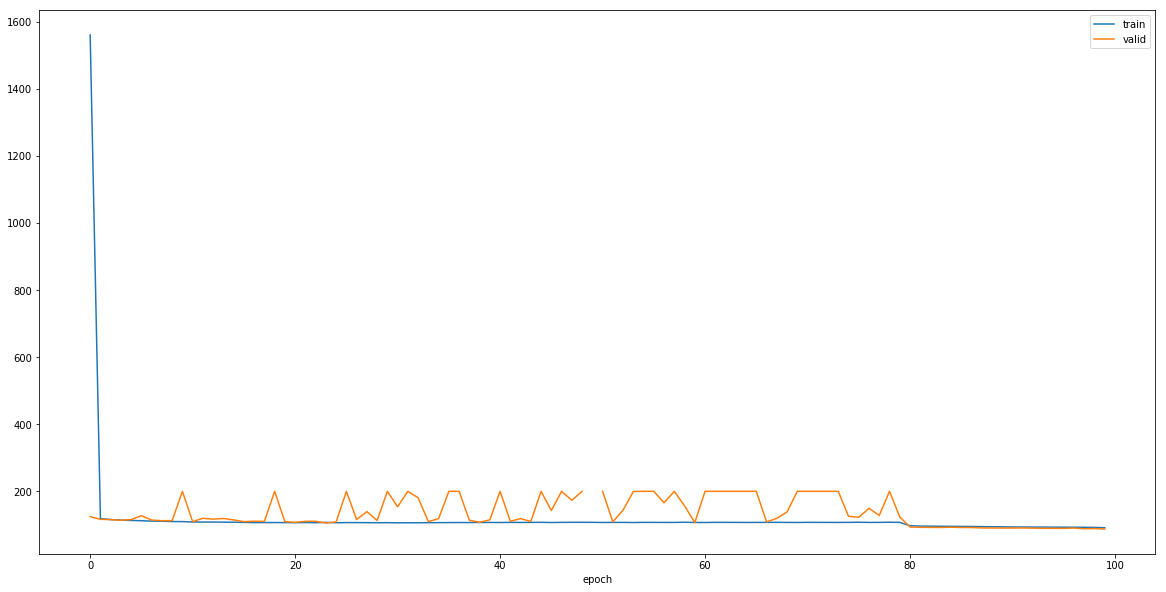

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')